# Graduate Project of BP Regression version 7.0 - Final Version

## Initialize machine learning library

In [350]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as opt
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
plt.close('all')
print(torch.__version__)

2.6.0+cpu


### Set computing device as CPU

In [351]:
device = torch.device("cpu")
print(f"Using Device: {device}")

Using Device: cpu


## Data load in and pre-processing

In [352]:
res_df = pd.read_csv("../data/data_trans.csv", header=0)
res = res_df.iloc[:, :5]

Check data shape

In [353]:
print("data dimension:", res.shape)

data dimension: (324, 5)


### Draw original feature-describing histograms

In [354]:
lab = pd.DataFrame({
    'Al thickness': res.iloc[:, 0],
    'LN thickness': res.iloc[:, 1],
    'SAW half-wavelength': res.iloc[:, 2],
})

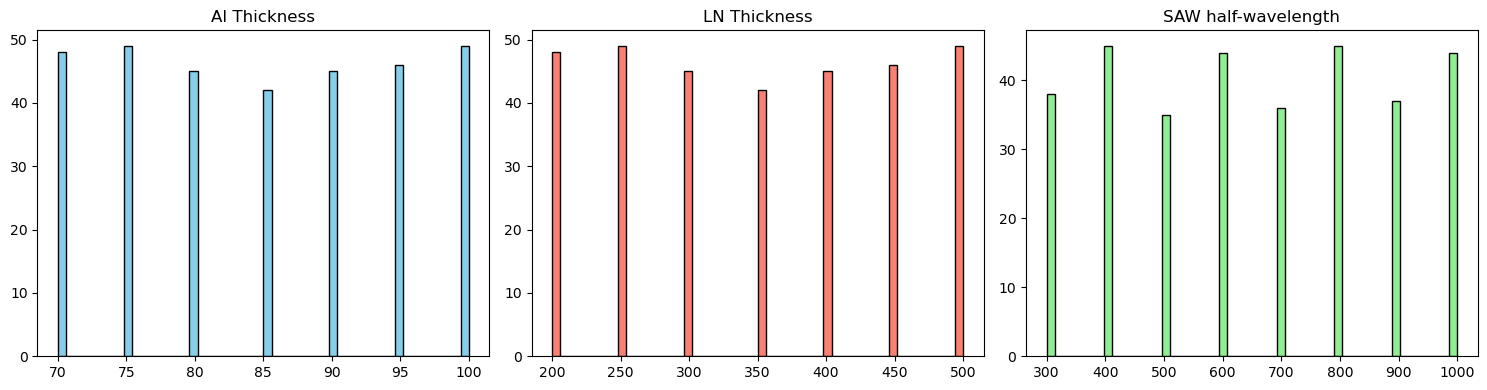

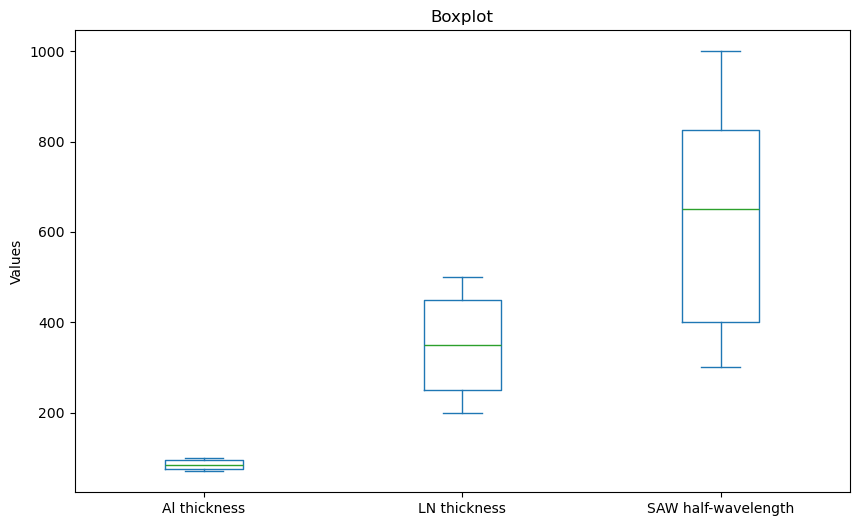

In [355]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(lab['Al thickness'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Al Thickness')

axes[1].hist(lab['LN thickness'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('LN Thickness')

axes[2].hist(lab['SAW half-wavelength'], bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('SAW half-wavelength')

# 自动调整子图间距
plt.tight_layout()
plt.show()
lab.describe()

lab.plot(kind='box', figsize=(10, 6))
plt.title("Boxplot")
plt.ylabel("Values")
plt.show()

### Set label and transform it into a nparray

In [356]:
labels = np.array(res.iloc[:,3:])
features = np.array(res.iloc[:, :3])
lab.describe()

,Al thickness,LN thickness,SAW half-wavelength
count,324.000000,324.000000,324.000000
mean,84.953704,349.537037,653.703704
std,10.195353,101.953528,230.530117
min,70.000000,200.000000,300.000000
25%,75.000000,250.000000,400.000000
50%,85.000000,350.000000,650.000000
75%,95.000000,450.000000,825.000000
max,100.000000,500.000000,1000.000000


## Exploratory Data Analysis

### Show the variation of respective features

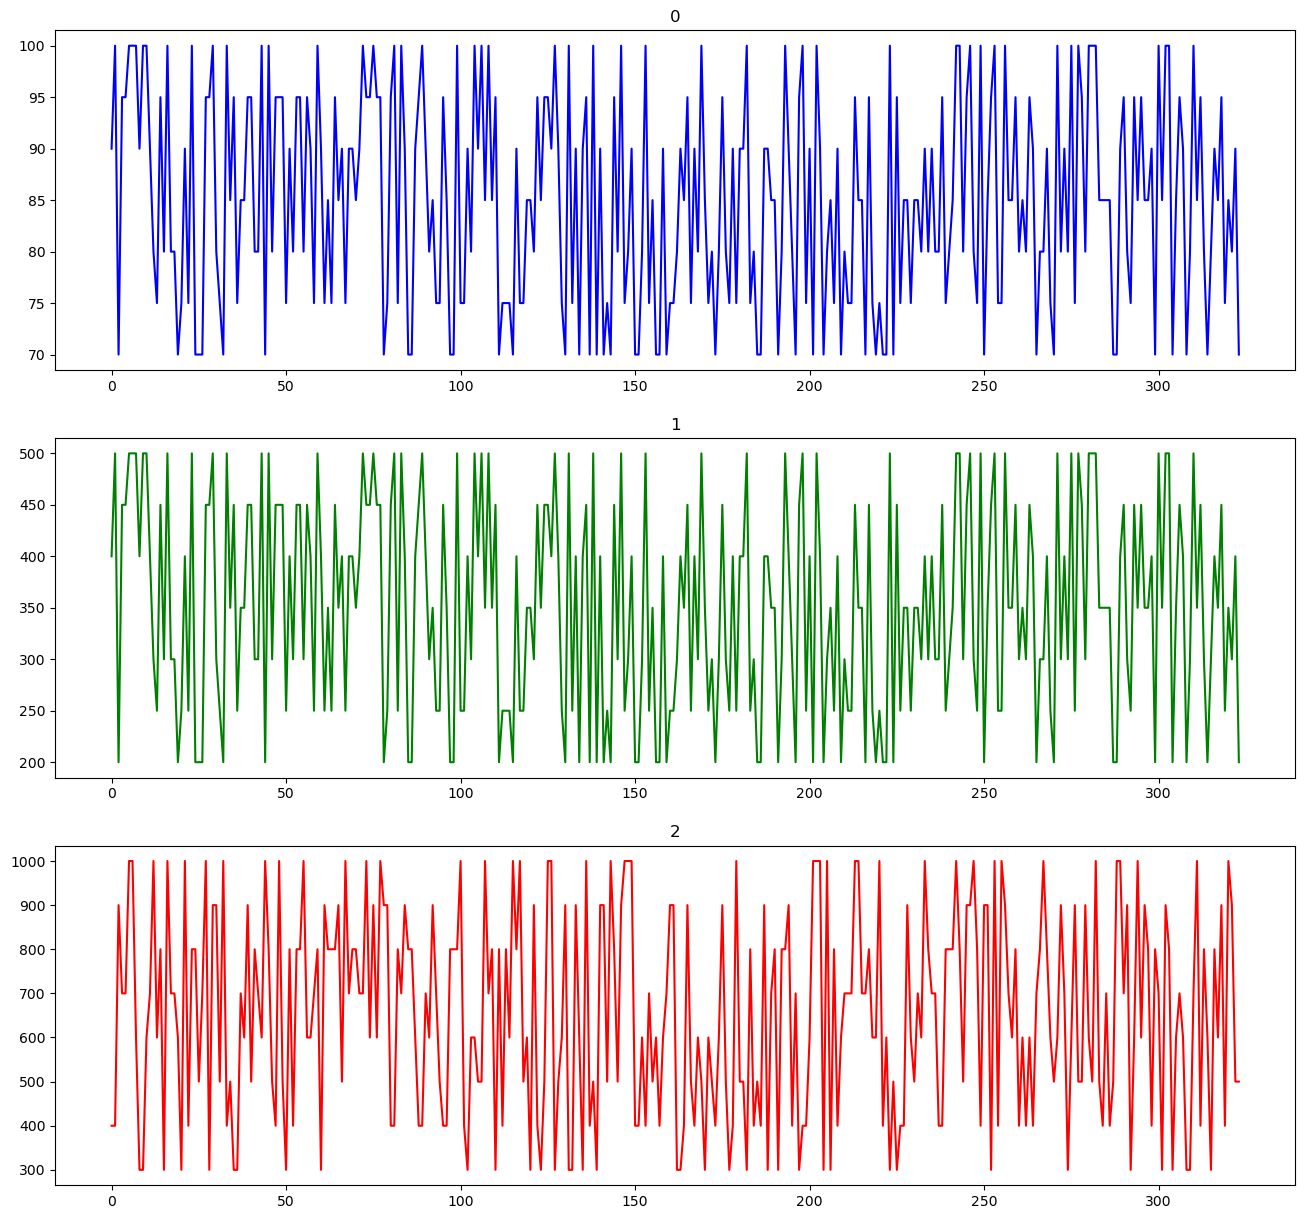

In [357]:
plt.figure(figsize=(16,15))
color = ['b', 'g', 'r']
for i in range(3):
  plt.subplot(3,1, i+1)
  a, = plt.plot(features[:,i],color= color[i])
  plt.title(i)

plt.show()

### Data standardization using sklearn

In [358]:
import seaborn as sns
import joblib
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(features, labels, train_size = 0.8, shuffle = True, random_state = 2019)

scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.StandardScaler()
scaled_x_train = scaler_x.fit_transform(x_train)
scaled_x_val = scaler_x.transform(x_val)

scaled_y_train = scaler_y.fit_transform(y_train)
scaled_y_val = scaler_y.transform(y_val)

## Split data set into training and validating

In [359]:
M_train = x_train.shape[0] 
M_val = x_val.shape[0]  

print(M_train)
print(M_val)

x_train = torch.FloatTensor(scaled_x_train)
y_train = torch.FloatTensor(scaled_y_train)
x_val = torch.FloatTensor(scaled_x_val)

259
65


### Set up BPNet

In [360]:
class BPNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BPNet, self).__init__()
        self.layers = nn.ModuleList()
        current_size = input_size
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(current_size, hidden_size))
            self.layers.append(nn.Tanh())
            current_size = hidden_size
        self.layers.append(nn.Linear(current_size, output_size)) # 'purelin' equivalent (no activation)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Constract BP Network

### Import torch libraries

In [361]:
import torch.nn as nn
from torch.nn import Conv1d 
from torch.nn import MaxPool1d 
from torch.nn import Flatten 
from torch.nn import AvgPool1d
from torch.nn import BatchNorm1d
from torch.nn import Linear 
from torch.utils.data import DataLoader, TensorDataset 
import torch.optim as optim
import torch.nn.functional as F

### Define Hyper-parameters and set dataloader

In [362]:
input_size = scaled_x_train.shape[1]
output_size = scaled_y_train.shape[1]
hidden_layer_config = [4,8,16,8,4]

model = BPNet(input_size, hidden_layer_config, output_size)
print("Model Architecture:")
print(model)

Model Architecture:
BPNet(
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): Tanh()
    (8): Linear(in_features=8, out_features=4, bias=True)
    (9): Tanh()
    (10): Linear(in_features=4, out_features=2, bias=True)
  )
)


### Set Training Parameters

In [363]:
epochs = 5000
learning_rate = 0.01
goal_loss = 1e-6

criterion = nn.MSELoss()  # Mean Squared Error Loss (common for regression)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer

### Training BPNet model

In [364]:
print("\nStarting Training...")
for epoch in range(epochs):
    model.train()  # Set model to training mode
    
    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update weights
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')
    
    if loss.item() <= goal_loss:
        print(f'Goal error tolerance ({goal_loss}) reached at epoch {epoch+1}. Training stopped.')
        break
print("Training Finished.")


Starting Training...
Epoch [100/5000], Loss: 0.98330230
Epoch [200/5000], Loss: 0.96685851
Epoch [300/5000], Loss: 0.95495468
Epoch [400/5000], Loss: 0.94354653
Epoch [500/5000], Loss: 0.91235387
Epoch [600/5000], Loss: 0.90415519
Epoch [700/5000], Loss: 0.89783394
Epoch [800/5000], Loss: 0.88678306
Epoch [900/5000], Loss: 0.87533355
Epoch [1000/5000], Loss: 0.86502999
Epoch [1100/5000], Loss: 0.86468792
Epoch [1200/5000], Loss: 0.85474205
Epoch [1300/5000], Loss: 0.84827369
Epoch [1400/5000], Loss: 0.84739417
Epoch [1500/5000], Loss: 0.83478993
Epoch [1600/5000], Loss: 0.83723497
Epoch [1700/5000], Loss: 0.83328831
Epoch [1800/5000], Loss: 0.82729149
Epoch [1900/5000], Loss: 0.82285750
Epoch [2000/5000], Loss: 0.82350129
Epoch [2100/5000], Loss: 0.82248765
Epoch [2200/5000], Loss: 0.81753349
Epoch [2300/5000], Loss: 0.82126546
Epoch [2400/5000], Loss: 0.81664860
Epoch [2500/5000], Loss: 0.81503952
Epoch [2600/5000], Loss: 0.81502587
Epoch [2700/5000], Loss: 0.81767911
Epoch [2800/500

## Simulation

In [300]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    y_sim1_scaled = model(x_train)
    y_sim2_scaled = model(x_val)

In [301]:
# %% Data Denormalization
# Convert PyTorch tensors to NumPy arrays for scalers
y_sim1_scaled_np = y_sim1_scaled.numpy()
y_sim2_scaled_np = y_sim2_scaled.numpy()

num_output_features_to_evaluate = scaled_y_train.shape[1]

### Compare predictions to actural values


**************************************************
           Metrics for Output Feature 1           
**************************************************


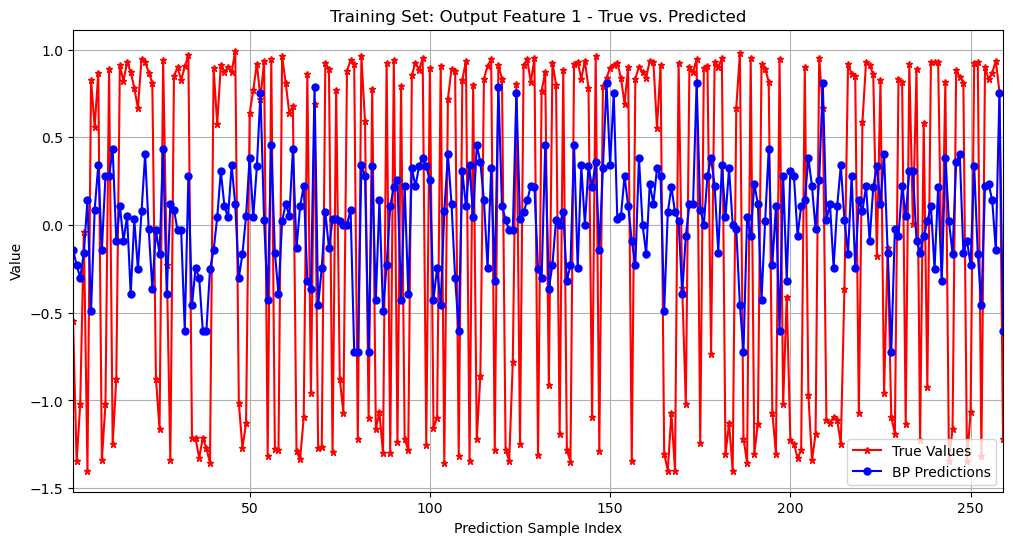

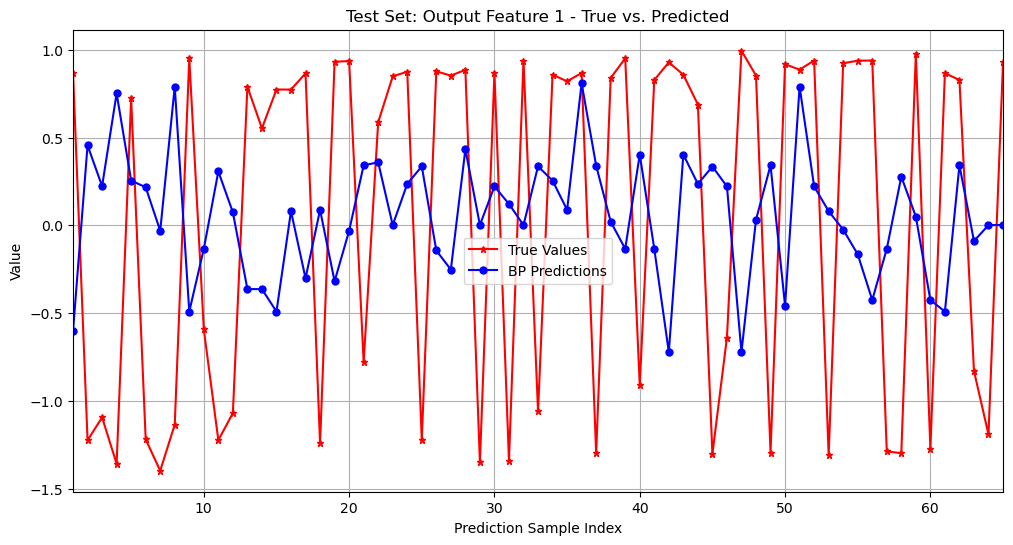

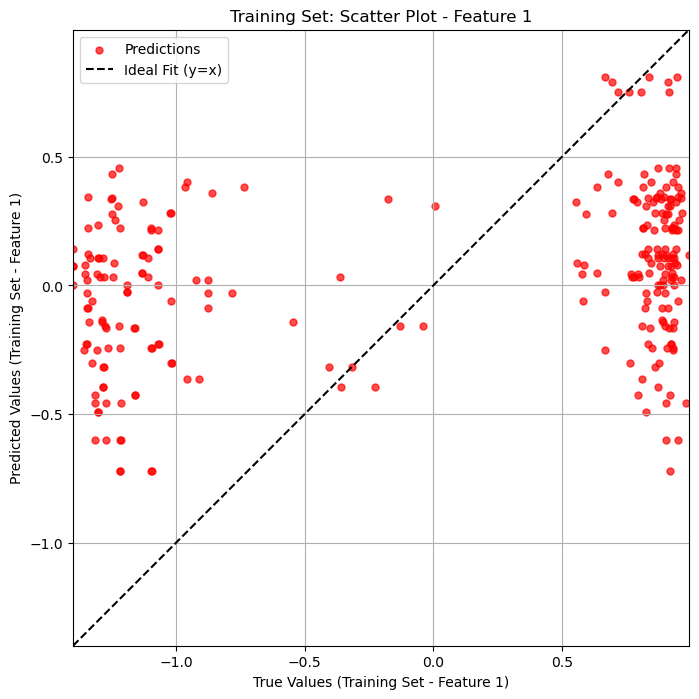

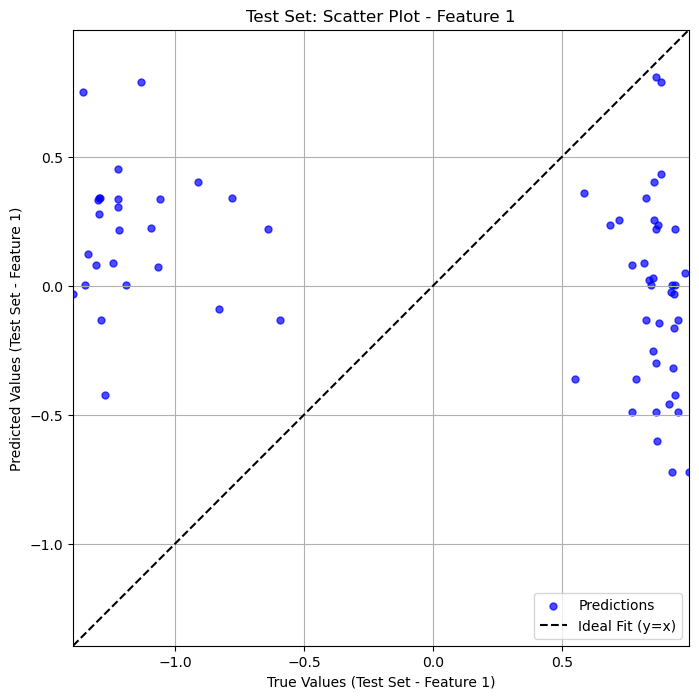

Training Set R2: 0.0963
Test Set     R2: -0.3748
Training Set MSE: 0.9037
Test Set     MSE: 1.3664

**************************************************
           Metrics for Output Feature 2           
**************************************************


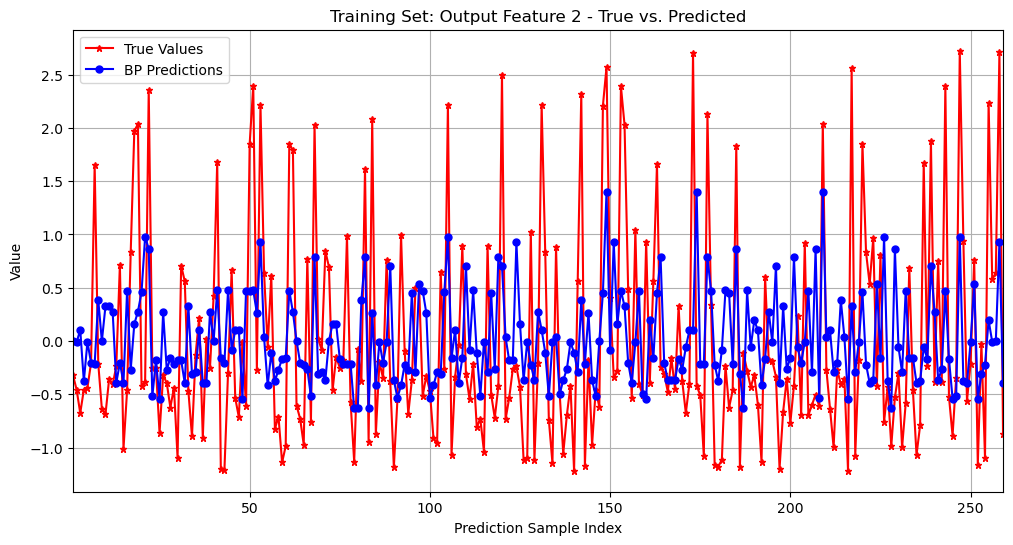

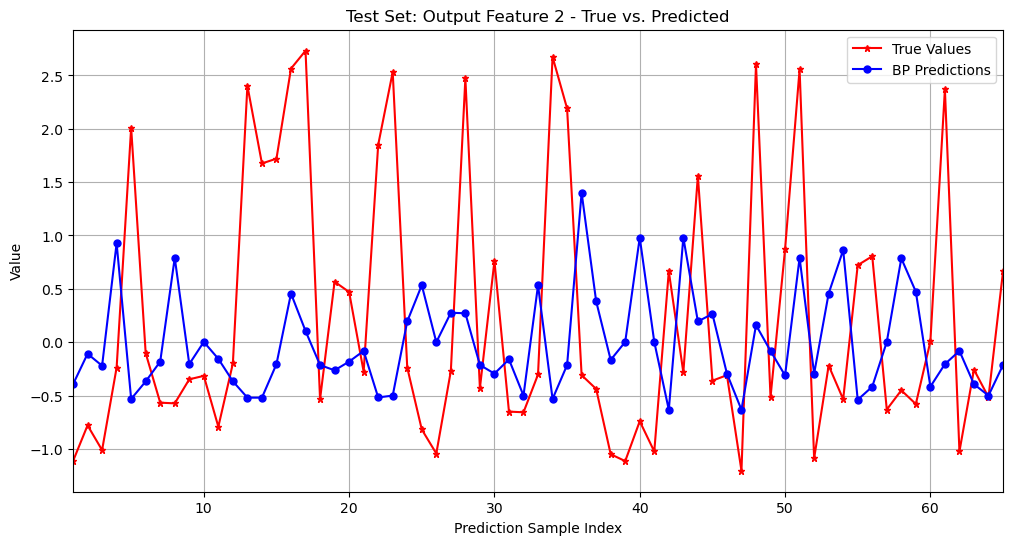

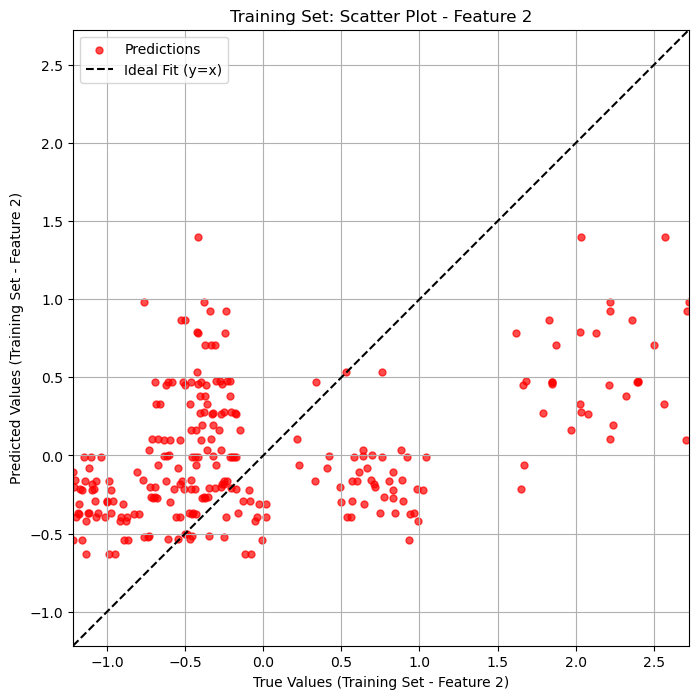

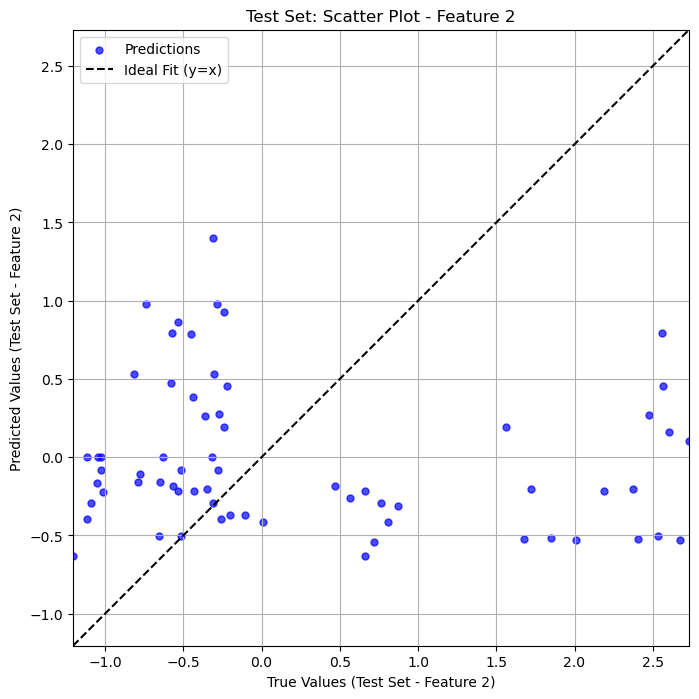

Training Set R2: 0.1882
Test Set     R2: -0.3064
Training Set MSE: 0.8118
Test Set     MSE: 1.9508


In [302]:
for i in range(num_output_features_to_evaluate):
    print(f"\n**************************************************")
    print(f"           Metrics for Output Feature {i+1}           ")
    print(f"**************************************************")

    # Extract current feature's true values and predictions
    T_train_feat_true = scaled_y_train[:, i]
    T_sim1_feat_pred = y_sim1_scaled_np[:, i]
    T_test_feat_true = scaled_y_val[:, i]
    T_sim2_feat_pred = y_sim2_scaled_np[:, i]
    

    # %% Plotting: Line plot of True vs. Predicted values
    # Training set
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, M_train + 1), T_train_feat_true, 'r-*', label='True Values', markersize=5)
    plt.plot(np.arange(1, M_train + 1), T_sim1_feat_pred, 'b-o', label='BP Predictions', markersize=5)
    plt.legend()
    plt.xlabel('Prediction Sample Index')
    plt.ylabel('Value')
    plt.title(f'Training Set: Output Feature {i+1} - True vs. Predicted')
    plt.xlim([1, M_train])
    plt.grid(True)
    plt.show()

    # Test set
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(1, M_val + 1), T_test_feat_true, 'r-*', label='True Values', markersize=5)
    plt.plot(np.arange(1, M_val + 1), T_sim2_feat_pred, 'b-o', label='BP Predictions', markersize=5)
    plt.legend()
    plt.xlabel('Prediction Sample Index')
    plt.ylabel('Value')
    plt.title(f'Test Set: Output Feature {i+1} - True vs. Predicted')
    plt.xlim([1, M_val])
    plt.grid(True)
    plt.gcf().set_facecolor('w') # Set figure background to white
    plt.show()

    # %% Plotting: Scatter plot of True vs. Predicted values
    # Training set
    plt.figure(figsize=(8, 8))
    min_val_train = min(np.min(T_train_feat_true), np.min(T_sim1_feat_pred))
    max_val_train = max(np.max(T_train_feat_true), np.max(T_sim1_feat_pred))
    plt.scatter(T_train_feat_true, T_sim1_feat_pred, s=25, c='red', alpha=0.7, label='Predictions')
    plt.plot([min_val_train, max_val_train], [min_val_train, max_val_train], '--k', label='Ideal Fit (y=x)')
    plt.xlabel(f'True Values (Training Set - Feature {i+1})')
    plt.ylabel(f'Predicted Values (Training Set - Feature {i+1})')
    plt.title(f'Training Set: Scatter Plot - Feature {i+1}')
    plt.xlim([min_val_train, max_val_train])
    plt.ylim([min_val_train, max_val_train])
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    # Test set
    plt.figure(figsize=(8, 8))
    min_val_test = min(np.min(T_test_feat_true), np.min(T_sim2_feat_pred))
    max_val_test = max(np.max(T_test_feat_true), np.max(T_sim2_feat_pred))
    plt.scatter(T_test_feat_true, T_sim2_feat_pred, s=25, c='blue', alpha=0.7, label='Predictions')
    plt.plot([min_val_test, max_val_test], [min_val_test, max_val_test], '--k', label='Ideal Fit (y=x)')
    plt.xlabel(f'True Values (Test Set - Feature {i+1})')
    plt.ylabel(f'Predicted Values (Test Set - Feature {i+1})')
    plt.title(f'Test Set: Scatter Plot - Feature {i+1}')
    plt.xlim([min_val_test, max_val_test])
    plt.ylim([min_val_test, max_val_test])
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
    # %% Other Relevant Metrics
    # R-squared (Coefficient of Determination)
    r2_train = r2_score(T_train_feat_true, T_sim1_feat_pred)
    r2_test = r2_score(T_test_feat_true, T_sim2_feat_pred)
    print(f"Training Set R2: {r2_train:.4f}")
    print(f"Test Set     R2: {r2_test:.4f}")
    
    # Mean Squared Error (MSE)
    mse_train = mean_squared_error(T_train_feat_true, T_sim1_feat_pred)
    mse_test = mean_squared_error(T_test_feat_true, T_sim2_feat_pred)
    print(f"Training Set MSE: {mse_train:.4f}")
    print(f"Test Set     MSE: {mse_test:.4f}")